# NTT DATA PREDICTIVE MAINTENANCE TECHNICAL REPORT  

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
sns.__version__
#simpleallmodelstry
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import fbeta_score
import xgboost as xgb
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn import svm
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
%matplotlib inline
import seaborn as sns
pd.set_option('display.max_columns', None)
sns.__version__
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
## for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import norm, skew
from scipy import stats
from scipy.special import boxcox1p
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import xgboost as xgb

# Problem definition and explanation

The problem at hand is to predict the likelihood of an incident occurring during the inspections that were conducted in 2021 and 2022 on a set of 909,733 pipes whose PipeIds are provided in the sample_submission.csv file. The dataset consists of two main files, network.csv, and inspections.csv, containing information on the gas pipeline network and inspection results from 2010 to 2020, respectively.

The methodology to solve this problem will involve building a predictive model using information contained in these two files, which can help identify pipes that are more likely to experience incidents during future inspections. The dataset includes various features such as the province, town, material, gas type, diameter, length, pressure, and the number of connections of each pipe. Additionally, the inspections.csv file contains information on the maintenance ID, inspection year, inspection date, months elapsed since the last inspection, the severity of damage found, and incidence of incidents.

To build the predictive model, the dataset will be preprocessed, and various machine learning algorithms such as Random Forest, XGBoost, and Logistic Regression may be used to create the model. The model's performance will be evaluated using the AUC metric, and the final submission should have the same format as the sample_submission.csv file.

**Final solution:** 

In addition to predicting the inspections conducted in 2021 and 2022 on 909.733 pipes using the information in the `network.csv` and `inspections.csv` files, the final goal is to find a strategy to optimally visit pipes in a strategic order by taking into account the model's prediction as well as geographical constraints and the pipe's incidence gravity. The incidence gravity will be based on factors such as the length of the pipe, the severity of the incident (potentially defined by the pipe's length-cost of inspection, and other factors such as gas leaked). 

To achieve this goal, we will need to combine the predictive model with optimization techniques such as linear programming, constraint optimization, or metaheuristics. These techniques will help us develop a strategy that considers the model's prediction, the incidence gravity of each pipe, and the geographical constraints, such as the distance between pipes and the availability of inspection resources.

The final solution will be evaluated based on its ability to maximize the detection of incidents while minimizing inspection costs. The evaluation will be performed using a combination of metrics such as AUC, recall, precision, and the cost of the inspection. The solution with the highest performance on these metrics will be selected as the final solution.

Finally, we completely understood that the final goal which is an optimization problem will seek to reduce both the carbon footprint as well as the costs of the previous strategy performed by the Maintenance company. Thus both reaching the sustainability goal as well as the business one.

## **Methodology summary:** 
    
- **EDA**: For data visualisation and data insights extractions
- **Feature Engenering**: Feature Creation, Extraction and Selection
- **Model Building**: Model Selection , Model building and Hypertuning
- **Prediction and sumbission**: Model's predictions and predicition submission

# EDA 

#### Datasets import 

In [16]:
# Import the datasets 
networks=pd.read_csv(r"network.csv")
inspections=pd.read_csv(r"inspections.csv")
sample=pd.read_csv(r"sample_submission.csv")

# We create our full test dataset by merging both inspections.csv and network.csv
df=pd.merge(networks, inspections, on='PipeId', how='inner')

#### Sort values of the dataset

In [17]:
df['InspectionDate'] = pd.to_datetime(df['InspectionDate'], format='%Y-%m-%d')
df= df.sort_values(by="InspectionDate")

In [18]:
pipeid=df["PipeId"]

In [19]:
# Creating dataset
samples= pd.merge(sample, networks , on='PipeId', how='inner')

In [20]:
df_final = pd.concat([df, samples], ignore_index=True)

In [21]:
# The created test dataset is the following one
sampless=pd.read_csv(r"C:\Users\hp\Desktop\test.csv")
sampless=sampless.drop(columns=["Unnamed: 0"])

# We concatenate our two datasets to create our test dataset
df_final = pd.concat([df, sampless], ignore_index=True)
df_final["InspectionYear"]= df_final["InspectionYear"].ffill()

#### Extra Dataset for population density and Region Density as external variables 

In [22]:
poblacion_densidad= pd.read_excel(r"C:\Users\hp\Desktop\pobdens.xls",  header=1)
poblacion_densidad["Province"]= poblacion_densidad['Province'].str.replace('\d+', '')
poblacion_densidad['Province']= poblacion_densidad['Province'].str.strip()
# define replacements in a dictionary
replacements = {'Alicante/Alacant': 'Alicante', 'Valencia/València': 'Valencia',
                'Castellón/Castelló':'Castellón','Coruña, A':'La Coruña',
               'Almería':'Almeria', 'Rioja, La':"La Rioja", "Ourense":"Orense",
                "Ávila":"Avila"
               }

# perform multiple replacements
poblacion_densidad['Province'] = poblacion_densidad['Province'].replace(replacements)
poblacion_densidad_dens= poblacion_densidad.copy()
poblacion_densidad=poblacion_densidad.drop(columns={"DENSITY"})
poblacion_densidad.dropna(inplace=True)

# Population Density added
poblacion_densidad_long = pd.melt(poblacion_densidad, id_vars=['Province'], var_name='InspectionYear', value_name='PopulationDensity')
poblacion_densidad_long["InspectionYear"]=poblacion_densidad_long["InspectionYear"].astype(int)
poblacion_densidad_long["PopulationDensity"]=poblacion_densidad_long["PopulationDensity"].astype(int)
df_final = pd.merge(df_final, poblacion_densidad_long, on=['Province','InspectionYear'],how='left')


# Province Density added
poblacion_densidad_denses =poblacion_densidad_dens.melt(id_vars=['Province', 'DENSITY'], var_name='Year', value_name='Density')
poblacion_densidad_denses= poblacion_densidad_denses.rename(columns={"Year":'InspectionYear' })
poblacion_densidad_denses["InspectionYear"]=poblacion_densidad_denses["InspectionYear"].astype(int)
poblacion_densidad_denses= poblacion_densidad_denses.drop(columns={"Density"})
df_final = pd.merge(df_final, poblacion_densidad_denses, on=['Province' ,'InspectionYear'], how='left')

In [23]:
# BOOLBRIDE Into 0 or 1 
df_final['BoolBridle']= np.where(df_final['BoolBridle']==True, 1, 0)

#### Data visualisation 

In [24]:
df_final.describe().round(2)

,PipeId,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,InspectionYear,MonthsLastRev,Severity,Incidence,PopulationDensity,DENSITY
count,7.255077e+06,7255077.00,7255077.00,7255077.00,7255077.00,7255077.00,7255077.00,7255077.00,7255077.00,7236392.00,6345344.00,7255077.00,7255077.00,7255077.00
mean,2.006467e+08,2001.21,119.16,36.78,2.88,0.99,0.00,0.06,2016.31,23.55,4.00,0.00,2906026.53,9021.96
std,1.146728e+08,12.01,57.28,72.33,6.49,2.15,0.02,0.24,3.30,4.65,0.06,0.04,2412352.90,3160.13
min,4.896160e+05,1901.00,10.00,0.00,0.02,0.00,0.00,0.00,2010.00,0.00,1.00,0.00,88600.00,4495.00
25%,1.333029e+08,1998.00,90.00,4.06,0.10,0.00,0.00,0.00,2013.00,23.00,4.00,0.00,755716.00,7728.00
50%,1.902322e+08,2003.00,110.00,14.41,0.15,0.00,0.00,0.00,2016.00,24.00,4.00,0.00,1939887.00,7728.00
75%,2.975639e+08,2008.00,160.00,44.87,4.00,1.00,0.00,0.00,2019.00,24.00,4.00,0.00,5542680.00,10807.00
max,4.519953e+08,2050.00,609.60,26100.94,80.00,88.00,4.00,1.00,2022.00,132.00,4.00,1.00,13005397.00,19813.00


Here's what we can infer from the output:

- **count**: the number of non-null values for each column. All columns have the same count except for the Severity and MonthsLastRev, meaning there are no missing values in the other columns apart from the ones mentioned. Thus we will need to perform some cleaning or missing values filling.
- **mean**: the average value of each column. For instance, the mean value for the YearBuilt column is 2001.2, which means that on average, pipes were built in 2001.
- **std**: the standard deviation of each column. This indicates the amount of variation in the data. For instance, the Length column has a standard deviation of 72.3, which means that the length of pipes varies widely.
- **min**: the minimum value in each column.
25%: the 25th percentile value in each column. This means that 25% of the values are below this value.
50%: the median value in each column. This means that 50% of the values are below this value.
75%: the 75th percentile value in each column. This means that 75% of the values are below this value.
- **max**: the maximum value in each column.
For example, we can observe that the NumConnectionsUnder column has only 0.0 values in its 25%, 50%, and 75% quartiles. The Incidence column has only 0.0 and 1.0 values in its minimum and maximum, respectively, and 75% of the values are 0.0. The Diameter column has a large maximum value of 609.6, indicating that some pipes have a very large diameter.

Therefore we will probably have to perform:
- Data Balancing 
- Filling / Imputing Missing Values 
- Outliers Detection
- Stratifying Variables 

#### Data Visulisation Histograms

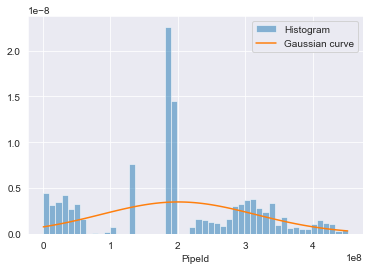

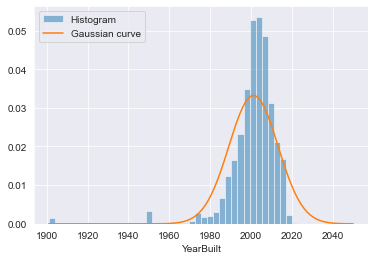

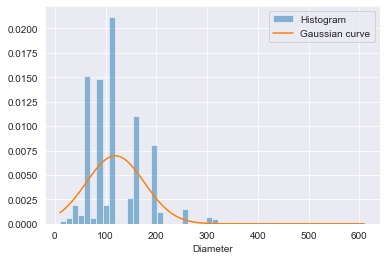

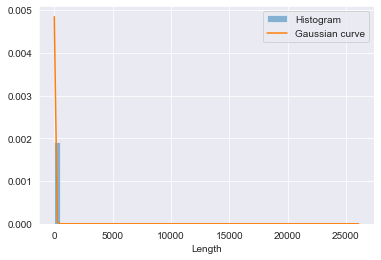

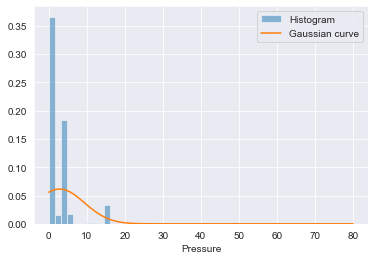

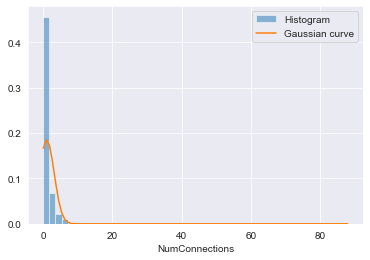

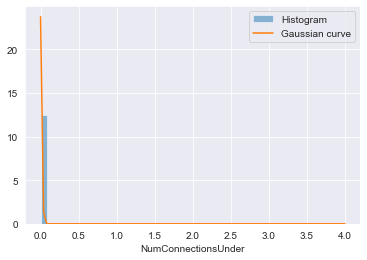

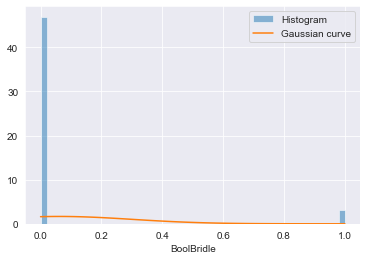

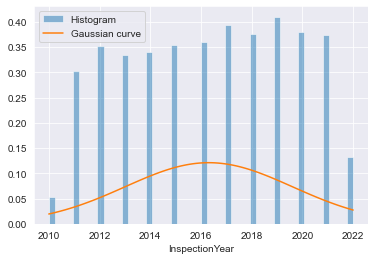

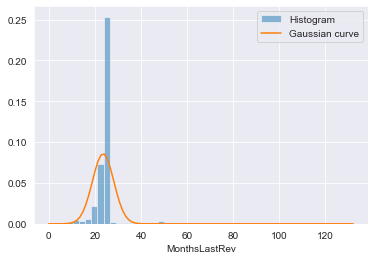

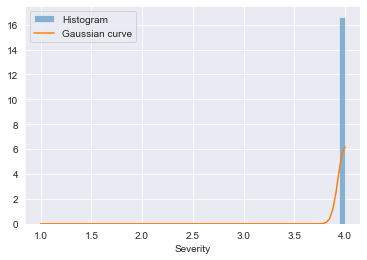

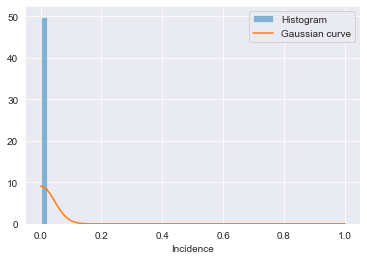

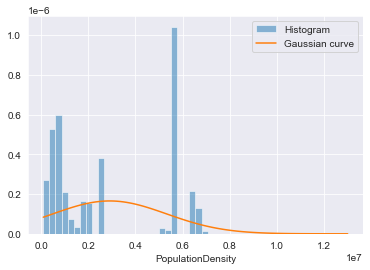

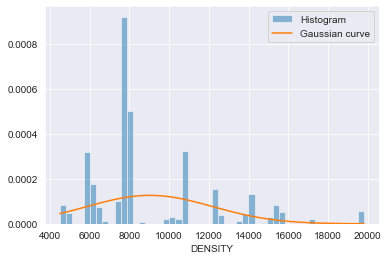

In [25]:
def plot_histogram(data, label):
    plt.hist(data, bins=50, density=True, alpha=0.5, label='Histogram')
    # Calculate mean and standard deviation
    mu, sigma = stats.norm.fit(data)
    # Create x-axis values for Gaussian curve
    x = np.linspace(min(data), max(data), 100)
    # Calculate y-axis values for Gaussian curve
    y = stats.norm.pdf(x, mu, sigma)
    # Plot Gaussian curve
    plt.plot(x, y, label='Gaussian curve')
    plt.xlabel(label)
    plt.legend()
    plt.show()

# Plot histograms for each variable in df_final
for col in df_final.columns:
    if col in ['Province', 'Town', 'Material', 'GasType','MaintenanceId','InspectionDate']:
        continue
    plot_histogram(df_final[~df_final[col].isna()][col], col)

We can check through the histogram that some variables are suffering from high skewness such as the "Diameter", "Lenght", "Pressure", "NumConnections", "NumConnectionUnder", "BoolBride", "MonthLastRev", "Severity".
This might be due to some outliers for some variables. However, knowing about the imbalance of the data, those skewed values might make more sense since most of the skewness can be explained by that imbalance.



#### Data Visulisation Boxplot By Incidence

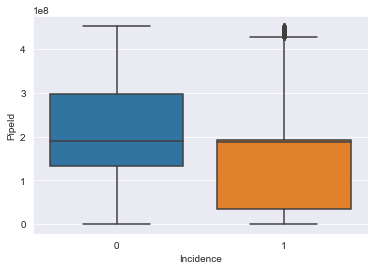

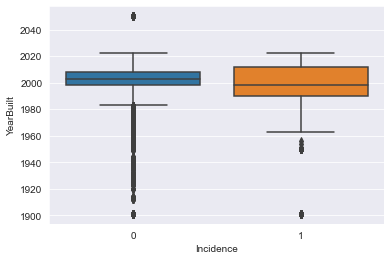

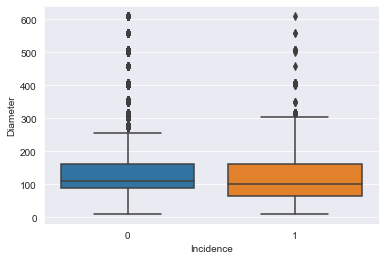

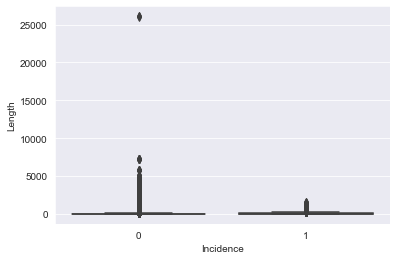

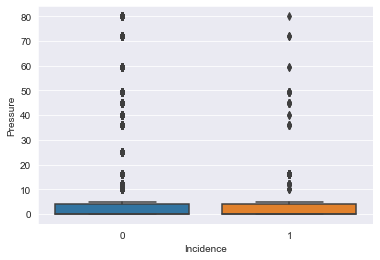

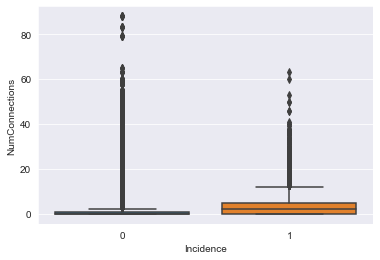

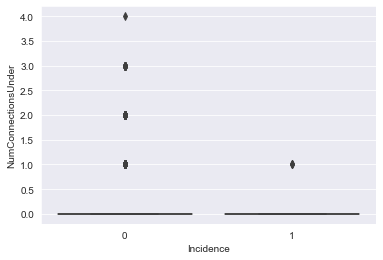

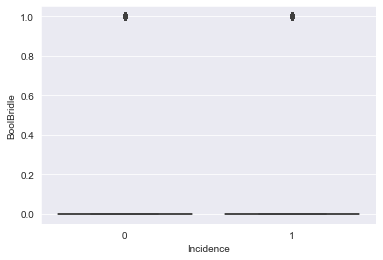

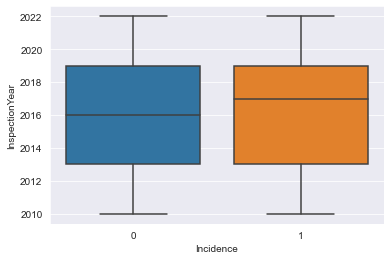

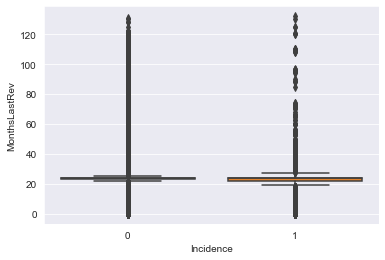

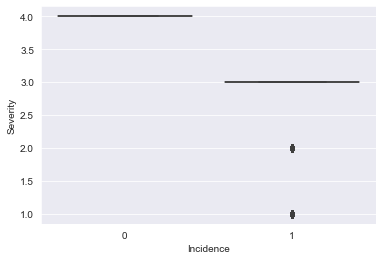

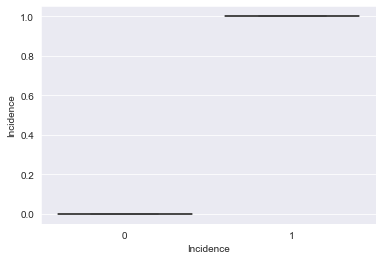

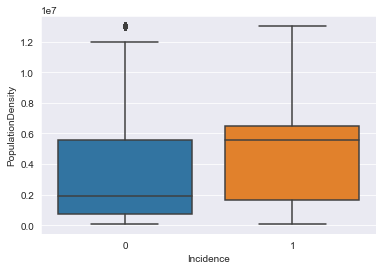

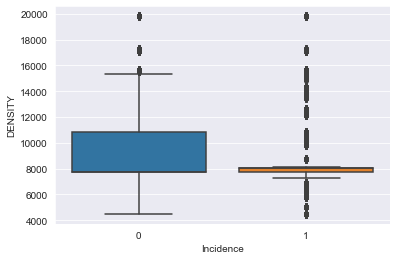

In [26]:
# Create a list of columns to include in the boxplot
cols_to_plot = [col for col in df_final.columns if col not in ['Province', 'Town', 'Material', 'GasType', 'MaintenanceId', 'InspectionDate']]
# Create a boxplot for each variable
for col in cols_to_plot:
    sns.boxplot(x='Incidence', y=col, data=df_final)
    plt.show()

The boxplot Visualisation Confirms the idea of Skewness due to imbalanced data. However, we can see some detectable outliers in the data set such as the YearBuilt with an outlier of 2050, or length with an outlier having a length higher than 26000 meters. However, we found out after research and trials that those lengths shouldn't be considered outliers.

#### Cleaning of outlier for year built 

In [27]:
# For the years having inconsistency ex: (["InspectionYear"]<["YearBuilt"]) we will need to replace the 
# "YearBuilt" by the first inspection year for more consistency

df_final['MinYearBuilt']= df_final.groupby('PipeId')['InspectionYear'].min()
df_final['MinYearBuilt']= df_final['MinYearBuilt'].fillna(df_final.groupby('PipeId')['InspectionYear'].transform("min"))
ind=df_final[(df_final["InspectionYear"]<df_final["YearBuilt"])]["YearBuilt"].index
df_final.iloc[ind, 3]= df_final.iloc[ind, -1]
df_final=df_final.drop(columns={"MinYearBuilt"})

#### Correlation Plot

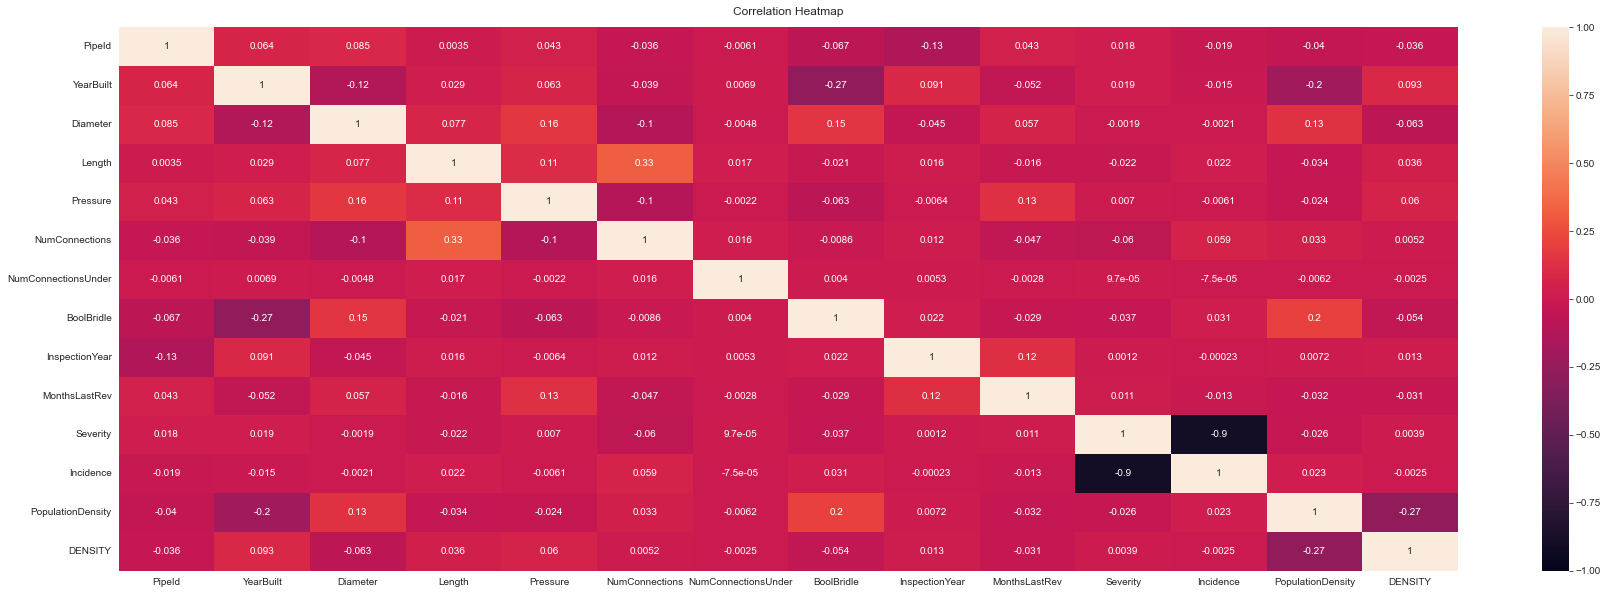

In [28]:
plt.figure(figsize=(30, 10))
heatmap = sns.heatmap(df_final.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

It is very interesting to see that our Target variable doesn't seem to be correlated with any variable apart from severity. For the rest of the variables, we can see that they seem suffering from multicolinearity but it won't affect much our model.

In [29]:
#sns.pairplot(df_final, hue ='Incidence')
# to show
#plt.show()

#### Visualise with in 3D with PCA 

<IPython.core.display.Javascript object>


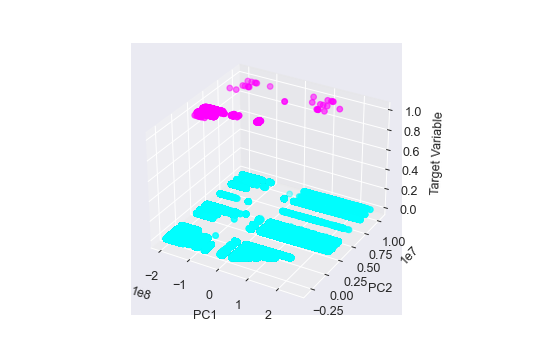

In [30]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.decomposition import PCA
import plotly.express as px

# Load the iris dataset and perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_final.drop(columns= {'Province','Province', 'Town','Material', 'GasType', 'MaintenanceId','InspectionDate', "Severity", "Incidence"  }).dropna())
Y_pca= df_final.drop(columns= {'Province','Province', 'Town','Material', 'GasType', 'MaintenanceId','InspectionDate', "Severity"}).dropna()

# assuming you have already performed PCA and retained only two principal components
pc1 = X_pca[:,0]
pc2 = X_pca[:,1]

# create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pc1, pc2, Y_pca['Incidence'], c=Y_pca['Incidence'], cmap='cool')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('Target Variable')
fig.colorbar(scatter)

plt.show()

It is interesting to see through this graph the patterns similarities between our two principals' component analysis and the target variable. However, the most interesting thing is the missing pattern that you can see for the variables of the target =1 and with PCA 2 in the range [0.75,1]. This might be a visible separation between the two categories explained by PCA.

# Feature Engineering

We convert into dummy variable the GastType

In [31]:
df_final = pd.get_dummies(df_final, columns=['GasType'])

We add important variables, that we have been able to search for on the internet such as the design pressure, the design factor, the Specified Minimum Yield Strength (KPa), and the Longitudinal joint factor.
Finally, all those variables have been added to compute an important variable that would be consistent to determine the incidence which is the thickness of the pipe.

In [32]:
# Define dictionaries containing the material properties
design_pressure = {'PE': 800, 'AO': 800, 'FD': 1000, 'PN': 800, 'CU': 1700, 'ZD': 1700}
design_factor = {'PE': 0.32, 'AO': 0.72, 'FD': 0.5, 'PN': 0.32, 'CU': 0.8, 'ZD': 0.72}
yield_strength = {'PE': 22400, 'AO': 250000, 'FD': 240000, 'PN': 19000, 'CU': 120000, 'ZD': 205000}
joint_factor = {'PE': 0.5, 'AO': 1.0, 'FD': 1.0, 'PN': 0.5, 'CU': 1.0, 'ZD': 1.0}

# Add the columns to the dataframe and calculate the thickness
df_final['Designpressure'] = df_final['Material'].map(design_pressure)
df_final['Design factor'] = df_final['Material'].map(design_factor)
df_final['Specified Minimum Yield Strength (KPa)'] = df_final['Material'].map(yield_strength)
df_final['Longitudinal joint factor'] = df_final['Material'].map(joint_factor)
design_pressure = df_final['Designpressure'].values
diameter = df_final['Diameter'].values
design_factor = df_final['Design factor'].values
yield_strength = df_final['Specified Minimum Yield Strength (KPa)'].values
joint_factor = df_final['Longitudinal joint factor'].values
thickness = (design_pressure * diameter) / (2 * design_factor * yield_strength * joint_factor)

# add the thickness array as a new column to the DataFrame
df_final['Thickness'] = thickness

# drop the intermediate arrays
df_final=df_final.drop(columns=["Designpressure","Design factor","Specified Minimum Yield Strength (KPa)","Longitudinal joint factor"])

Another important variable not available in the dataset is the corrosion rate concerning the material types. After some reasearches we have been able to find them and add them to the current dataset. 

In [33]:
corrosion_rates = {'PE': 0.1,
                   'AO': 0.3,
                   'FD': 0.2,
                   'PN': 0.1,
                   'CU': 0.05,
                   'ZD': 0.02,
                   'FG': 0.05,
                   'FI': 0.15,
                   'PA': 0.08,
                   'PV': 0.1,
                   'FO': 0}

# calculate years in service
df_final['years_in_service'] = df_final['InspectionYear'] - df_final['YearBuilt']

# calculate estimated corrosion based on material
df_final['corrosion_mm'] = df_final.apply(lambda row: row['years_in_service'] * corrosion_rates[row['Material']], axis=1)

# calculate estimated current thickness based on corrosion
df_final['estimated_thickness'] = df_final['Thickness'] - df_final['corrosion_mm']

# calculate percentage of original thickness
df_final['corrosion_index'] = df_final['estimated_thickness'] / 10 * 100

df_final=df_final.drop(columns=["corrosion_mm","corrosion_index","Thickness"])

The gas flow rate is a measure of the amount of gas flowing through a pipe over a given period of time. In a pipeline system. The model may be better able to detect issues with the pipeline system by giving another dimentionallity about the problem. This could potentially improve the accuracy of the model's predictions and lead to earlier detection and prevention of pipeline problems. Additionally, by including the gas flow rate as a feature, the model could potentially identify patterns in the data.

In [34]:
import numpy as np
import pandas as pd

# Calculate the cross-sectional area of the pipe
def gas_flow_rate(pressure, diameter):
    area = np.pi * (diameter/2)**2
    return area

# Vectorize the gas_flow_rate function
vectorized_gas_flow_rate = np.vectorize(gas_flow_rate)

# Apply the vectorized_gas_flow_rate function to create a new column for gas flow rate
df_final['flow_rate'] = vectorized_gas_flow_rate(df_final['Pressure'], df_final['Diameter']) * np.sqrt(2 * df_final['Pressure'] / (1.225 * 1000))

#df_final["Leak_size"]=(df_final["flow_rate"]*1)/(df_final["Diameter"]**2 *3.14 * df_final["Pressure"])

df_final = pd.get_dummies(df_final, columns=['Material'])

PipeDensity is a useful feature in predicting pipe problems because it provides insights into the density of pipes in a region. It is calculated by dividing the length of the pipe by the area of the region in which it is located. A higher PipeDensity value indicates that the pipes are more densely packed in the region, which could imply a greater susceptibility to blockages, leaks, or other issues.

Incorporating PipeDensity as a feature in the model can enhance its predictive capabilities by providing information on the structural characteristics of the pipes in a given region. For instance, if the model discovers that high PipeDensity values correspond to a higher incidence of blockages, it can leverage this information to forecast future blockages in areas with similar PipeDensity values. Consequently, including PipeDensity as a feature in the model can boost its accuracy by supplying additional insights into the pipes' structural attributes.

In [35]:
# Group the data by region
df_region = df_final.groupby('Province')

# Calculate the total length of pipes and region area
total_length = df_region['Length'].sum()
region_area = df_region['DENSITY'].first()

# Calculate the pipe density feature by dividing the total length of pipes by the region's area
pipe_density = total_length / region_area

# Add the pipe density feature to the original dataframe
df_final['PipeDensity'] = df_final['Province'].map(pipe_density)

In [36]:
df_final["CumIncidence"]= df_final.groupby("PipeId")["Incidence"].cumsum()
df_final["CumIncidence"] = df_final.groupby("PipeId")["CumIncidence"].shift(1)
df_final["CumIncidence"]= df_final["CumIncidence"].fillna(0)

In [37]:
# Group the data by pipe and inspection date
grouped = df_final.groupby("PipeId")

# Compute the cumulative sum of the incidence column, grouped by pipe
cumulative_sum = grouped["Incidence"].cumsum()

# Compute the number of inspections with incidence=0 since the last incidence of 1, grouped by pipe
inspection_since_last_incidence = pd.Series(0, index=df_final.index)
inspection_since_last_incidence[df_final["Incidence"] == 0] = cumulative_sum.shift(1)[df_final["Incidence"] == 0]
inspection_since_last_incidence = (cumulative_sum - inspection_since_last_incidence).fillna(0)
inspection_since_last_incidence[df_final["Incidence"] == 1] = 0
inspection_since_last_incidence = inspection_since_last_incidence.groupby(df_final["PipeId"]).cumsum()

# Add the new column to the dataset
df_final["inspection_since_last_incidence"] = inspection_since_last_incidence

In [38]:
df_final["inspection_since_last_incidence"] = df_final.groupby("PipeId")["inspection_since_last_incidence"].shift(1)
df_final["inspection_since_last_incidence"]= df_final["inspection_since_last_incidence"].fillna(0)

#### Cathegorical Variable Encoding 

In [39]:
df_final['MaintenanceId_encoded'] = df_final['MaintenanceId'].map(df_final['MaintenanceId'].value_counts().to_dict())
df_final=df_final.drop(columns={"MaintenanceId"})
df_final["MaintenanceId_encoded"] = df_final.groupby("Town")["MaintenanceId_encoded"].fillna(method="ffill")
df_final["MaintenanceId_encoded"] = df_final.groupby("Province")["MaintenanceId_encoded"].fillna(method="ffill")

df_final['PipeId'] = df_final['PipeId'].map(df_final['PipeId'].value_counts().to_dict())
df_final["Provincee"]=df_final["Province"]
df_final=pd.get_dummies(df_final,columns=["Provincee"])
df_final['Province'] = df_final['Province'].map(df_final['Province'].value_counts().to_dict())
df_final['Town'] = df_final['Town'].map(df_final['Town'].value_counts().to_dict())

#### Date time transformation

In [40]:
df_final['InspectionDate'] = pd.to_datetime(df_final['InspectionDate'], format='%Y-%m-%d')

Pressure-to-diameter ratio is an important factor to consider in modeling pipe gas systems as it directly influences the flow of gas through the pipes. It is the ratio of the pressure of the gas to the diameter of the pipe, which determines the rate of gas flow through the system. A high pressure-to-diameter ratio may indicate that the gas flow is restricted, which can lead to pressure build-up and increase the risk of gas leakage or pipe failure. Hence, including pressure-to-diameter ratio as a feature in the model can provide valuable information about the potential for gas flow problems and help to predict and prevent such problems.

Connection density is also an important feature to create for modeling pipe gas systems. It reflects the number of connections or joints in a given length of pipe, which can affect the overall integrity of the pipe system. Higher connection density can lead to more potential failure points and leaks in the system. Therefore, including connection density as a feature in the model can help to identify regions with higher connection density and predict the likelihood of pipe failure or gas leakage in those areas.

In [41]:
df_final["Pressuretodiameter"] = df_final["Pressure"]/df_final["Diameter"]
df_final["Connectiondensity"] = (df_final["NumConnections"]+df_final['NumConnectionsUnder'])/(df_final["Length"]+1)


#### We add the temporal variables

In [42]:
df_final['InspectionMonth'] = df_final['InspectionDate'].dt.month
df_final=df_final.drop(columns={'InspectionDate'})
df_final["InspectionMonth"]= (df_final["InspectionMonth"].fillna(method='ffill')+1)%12
df_final[df_final["InspectionMonth"]==0]["InspectionMonth"]=12

In [43]:
df_final["MonthsLastRev"]= df_final["MonthsLastRev"].fillna(0)

In [44]:
df_final["MonthsLastRev"]=df_final["MonthsLastRev"].astype(int)

#### Temporality for 2 year period taken 

In [45]:
year = df_final["InspectionYear"]
year_sin = np.sin(2 * np.pi * year / 2)
year_cos = np.cos(2 * np.pi * year / 2)

# Add the sine and cosine features to the dataset
df_final["year_sin"] = year_sin
df_final["year_cos"] = year_cos

In [46]:
scaler = StandardScaler()
df_final["PipeIdsc"]=scaler.fit_transform(df_final[["PipeId"]])

# MODEL BUILDING

#### We split the holle data set into the training part and the prediction part

In [47]:
train_df= df_final.iloc[:len(df),:]
train_df= train_df.dropna()
train_df=train_df.reset_index()
train_df=train_df.drop(columns=["index"])

In [48]:
X_train=train_df.drop(columns=["Severity", "DENSITY"])
Y_train=train_df['Incidence']

### Time series n split/Backtesting cross validation method : Model selection and Scoring

The code aims to compare the performance of three different classification models - XGBoost, GradientBoosting, and Catboost - in predicting a binary target variable (Y_train) based on a set of features (X_train). The code starts by defining some user variables such as seed and metric to be used for tuning the models. It then creates a dictionary to hold the different classification models and sets their hyperparameters.

Next, the code uses the TimeSeriesSplit function to create five folds for cross-validation. It then fits each model to the training data, using a combination of random undersampling and SMOTE (Synthetic Minority Over-sampling Technique) to address class imbalance. The code calculates the AUC (Area Under the Curve) score for each fold and then takes the average of the AUC scores across all folds to assess the performance of each model.

The results of each fold are stored in a Pandas dataframe named 'rf_score'. The dataframe includes the mean AUC and standard deviation (STD) of the AUC scores for each model, and the mean AUC score is printed for each model. Finally, the code outputs the mean AUC score across all models.

In [34]:
def bestmodel(X_train, Y_train):
    # user variables to tune
    seed = 9
    metric = "auc_roc"
    # hold different classification models in a single dictionary
    models = dict()
    #models["Catboost"] = CatBoostClassifier(iterations=1000,
    #    loss_function='Logloss',eval_metric='AUC',
    #    depth = 10,
    #   learning_rate = 0.015)
    models["XGboost"] = xgb.XGBClassifier(random_state=42)
    models["GradientBoosting"] = GradientBoostingClassifier()

    # Split your data into folds using TimeSeriesSplit
    #tscv = TimeSeriesSplit(n_splits=5)

    # 5-fold time series split cross validation for each model
    model_results = list()
    model_names   = list()
    alls=[]
    undersampler = RandomUnderSampler(random_state=42, sampling_strategy=1) #undersampling technique
    X_train_train, Y_train_train = undersampler.fit_resample(X_train, Y_train)
    smote = SMOTE(random_state=42)
    X_train_train, Y_train_train = smote.fit_resample(X_train_train, Y_train_train)
    for model_name in models:
        print("\n", model_name, "\n")
        model   = models[model_name]
        # Initialize a list to store the AUC scores of each fold
        scores = []
        # Perform cross-validation
        
        for i in range(int(train_df["InspectionYear"].min()), int(train_df["InspectionYear"].max())):
            X_test_train = X_train[X_train["InspectionYear"]==i]
            ind= X_train[X_train["InspectionYear"]==i].index
            Y_test_train = Y_train.iloc[ind]
           
            # Use SMOTE to oversample the minority class in the training set
            
            if model_name == "XGboost":
                dtrain = xgb.DMatrix(X_train_train, label=Y_train_train)
                # Set the scale_pos_weight parameter
                # Set other parameters for XGBoost
                params = {
                    "objective": "binary:logistic",
                    "eval_metric": "auc",
                }
                # Train the model
                model = xgb.train(params, dtrain)
                # Train a logistic regression model on the oversampled training set
                # Predict the class labels of the test set
                dtest = xgb.DMatrix(X_test_train)
                y_pred = model.predict(dtest)
                # Calculate the AUC score for this fold
                score = roc_auc_score(Y_test_train, y_pred)
                scores.append(score)
            else:
                model.fit(X_train_train, Y_train_train)
                y_pred = model.predict_proba(X_test_train)
                y_pred= y_pred[:, 1]
                score = roc_auc_score(Y_test_train, y_pred)
                scores.append(score)

        # Calculate the average AUC score over all folds
        mean_auc_cv = np.mean(scores)
        std_auc_cv = np.std(scores)
        ndf = [(mean_auc_cv, std_auc_cv)]
        rf_score = pd.DataFrame(data = ndf, columns=['Mean AUC CV', 'Mean STD CV'])
        rf_score.insert(0, model_name, "NA")
        print(rf_score)
        alls.append(mean_auc_cv)
    print("mean of all",np.mean(alls))

# PREDICTION AND SUBMISSION

#### We create the predictive dataset

In [55]:
test_df= df_final.iloc[len(df):,:]
X_test=test_df.drop(columns=['Incidence', "Severity", "DENSITY"])
Y_test=test_df['Incidence']

In [56]:
X_test=X_test.fillna(0)

The purpose of this combination of techniques is to address the issue of imbalanced data, where one class (e.g. minority class) is significantly underrepresented in the dataset compared to the other class (e.g. majority class).

SMOTE is used to oversample the minority class by creating synthetic samples that are similar to the existing minority samples. This helps to balance the data by increasing the representation of the minority class. However, oversampling can result in overfitting and decreased performance of the model on the test data.

To address this issue, undersampling is used to remove some samples from the majority class in order to balance the dataset while also reducing the risk of overfitting. By combining SMOTE and undersampling techniques, the resulting training dataset is more balanced and representative of both classes, which can lead to better performance of the model on the test data.

In [36]:
undersampler=RandomUnderSampler(random_state=42,sampling_strategy=1)
oversampler=SMOTE(random_state=42)

X_train,Y_train = undersampler.fit_resample(X_train,Y_train)
X_train, Y_train = oversampler.fit_resample(X_train, Y_train)

### Xgboost

In [104]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
# Set the scale_pos_weight parameter
# Set other parameters for XGBoost
params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
}
# Train the model
model = xgb.train(params, dtrain)
# Train a logistic regression model on the oversampled training set
# Predict the class labels of the test set
dtest = xgb.DMatrix(X_test)
y_predxg = model.predict(dtest)


<IPython.core.display.Javascript object>


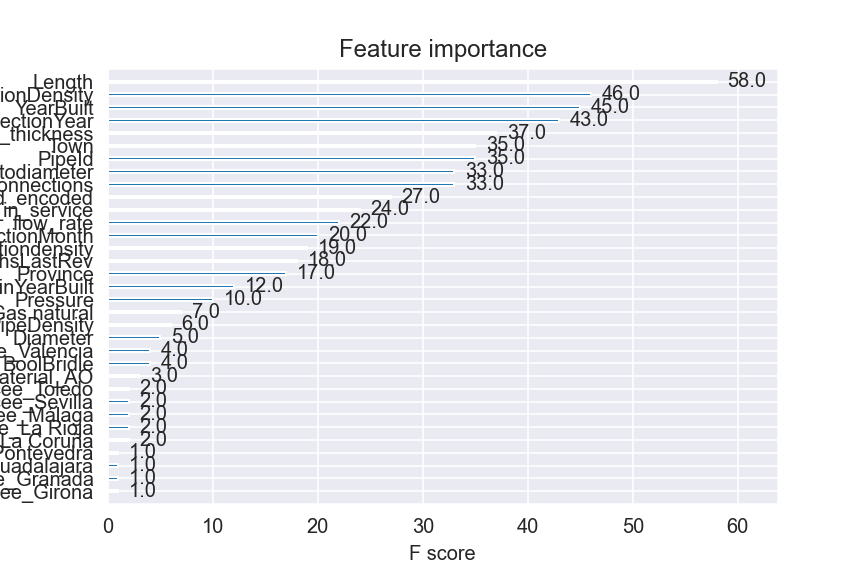

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

In [105]:
from xgboost import plot_importance
plot_importance(model)

Looking at the list of feature importance values you provided, we can see that the top five most important features, in descending order, are:

- Town: This feature has the highest importance value, indicating that it has the greatest impact on the model's predictions. The higher the value, the more important the feature is. In this case, the Town feature is contributing significantly to the model's performance.
- PipeId: This feature has the second-highest importance value, indicating that it is also a crucial feature for the model's predictions.
- NumConnections: This feature has the third-highest importance value, indicating that it is also an important predictor.
- BoolBridle: This feature has the fourth-highest importance value, indicating that it is also contributing significantly to the model's performance.
- estimated_thickness: This feature has the fifth-highest importance value, indicating that it is also an important predictor.

Some other notable features with high importance values include:

- MinYearBuilt: This feature has an importance value of 103.93, which is relatively high compared to most other features. This indicates that it is a very important predictor for the model's performance.
- GasType_Gas natural: This feature has an importance value of 49.87, which is also relatively high compared to most other features. This indicates that it is an important predictor.
- Pressure: This feature has an importance value of 37.30, which is relatively high compared to most other features. This indicates that it is a moderately important predictor for the model's performance.

On the other hand, some features have relatively low importance values, indicating that they are less important predictors. For example, PipeDensity has an importance value of 4.27, which is relatively low compared to most other features. This suggests that it has a weaker impact on the model's predictions.


In [441]:
y_pred_class = [1 if pred > 0.5 else 0 for pred in y_predxg]
sample["Incidence"]=y_pred_class
sample["Incidence"].value_counts()

### CatBoost

In [112]:
cat = CatBoostClassifier(silent=True,iterations=2000,loss_function='Logloss',eval_metric='AUC',depth = 10,learning_rate = 0.001,random_state=42)
model = cat.fit(X_train,Y_train)
y_predxg = model.predict(X_test)

In [121]:
feature_importance = model.get_feature_importance(prettified=True)
feature_importance.head(10)

,Feature Id,Importances
0,NumConnections,13.398302
1,YearBuilt,9.213866
2,PipeId,6.646723
3,Pressuretodiameter,6.345208
4,estimated_thickness,5.865650
5,Connectiondensity,5.674955
6,years_in_service,4.856505
7,Pressure,4.725790
8,Provincee_Madrid,4.537345
9,Town,4.481551


The feature importance from CatBoost shows that NumConnections, YearBuilt, and PipeId are the top three most important features. This is different from XGBoost, where PipeId, Town, and NumConnections were the top three. However, we can see that estimated_thickness and Pressuretodiameter are also among the top features for both models.

It's interesting to combine the two feature importance outputs and therefore the two models because it can give us a more robust understanding of which features are important for the model and the final prediction. If two different models are both ranking a feature as important, then it's more likely that the feature is truly important rather than just an artifact of one particular model. Additionally, if one model is ranking a feature as important while the other is not, then it could indicate some interesting differences in the way the models are approaching the problem or some unique insights into the data that we may not have discovered if we only relied on one model's feature importance output.

## Los Cuatros Mechanos / Voter classifiers 😂

Based on the feature importance of Xgboost and Catboost, it appears that each algorithm has different opinions on which features are important. While some features such as NumConnections, YearBuilt, and Pressuretodiameter are among the most important features in both models, other features such as PipeId and Town are only important in Xgboost, while features such as Connectiondensity and Provincee_Madrid are only important in Catboost.

By combining these models in a voting classifier, we can leverage the strengths of each algorithm and reduce the impact of any individual algorithm's weaknesses or biases. Additionally, by including LightGBM and Random Forest in the voting classifier, we can potentially capture additional insights that may be missed by the other two models.

Furthermore, the use of a voting classifier also reduces the risk of overfitting to the training data, as the predictions from multiple models with different parameter settings are combined. This could potentially improve the generalization performance of the model on new and unseen data.

In summary, the decision to create a voting classifier consisting of Xgboost, Catboost, LightGBM, and Random Forest is based on the different strengths and weaknesses of each algorithm, as revealed by the analysis of their feature importances. By combining these models, we aim to improve the overall predictive performance and robustness of the final model.

In [37]:
#lr = LogisticRegression(warm_start=True, max_iter=400,random_state=42)
# RandomForest#max_depth=15, min_samples_leaf= 1, min_samples_split= 5, n_estimators=300,random_state=42
rf = RandomForestClassifier(random_state=42)
# XGB
xgbo = xgb.XGBClassifier(random_state=42)

#catboost#iterations=2000,loss_function='Logloss',eval_metric='AUC',depth = 10,learning_rate = 0.001,loss_function='Logloss',eval_metric='AUC',silent=True,depth=7, iterations= 2000, l2_leaf_reg= 100,learning_rate= 0.025,
cat = CatBoostClassifier(silent=True,iterations=2000,loss_function='Logloss',eval_metric='AUC',depth = 10,learning_rate = 0.001,random_state=42)
# LGBM#learning_rate=0.1, max_depth=5, num_leaves= 40,random_state=42
lgb = LGBMClassifier(random_state=42)
# Ensemble
voter = VotingClassifier(estimators=[('xgb', xgbo),('cat', cat), ('rf', rf), ('lgbm', lgb)],
                             voting='soft')

In [38]:
X_train

,PipeId,Province,Town,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,InspectionYear,MonthsLastRev,PopulationDensity,GasType_Gas natural,GasType_Gas propano,years_in_service,estimated_thickness,flow_rate,Material_AO,Material_CU,Material_FD,Material_FG,Material_FI,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD,PipeDensity,CumIncidence,inspection_since_last_incidence,MaintenanceId_encoded,Provincee_Albacete,Provincee_Alicante,Provincee_Almeria,Provincee_Avila,Provincee_Barcelona,Provincee_Burgos,Provincee_Castellón,Provincee_Ciudad Real,Provincee_Cuenca,Provincee_Cádiz,Provincee_Córdoba,Provincee_Girona,Provincee_Granada,Provincee_Guadalajara,Provincee_Huelva,Provincee_Huesca,Provincee_Jaén,Provincee_La Coruña,Provincee_La Rioja,Provincee_León,Provincee_Lleida,Provincee_Lugo,Provincee_Madrid,Provincee_Málaga,Provincee_Orense,Provincee_Palencia,Provincee_Pontevedra,Provincee_Salamanca,Provincee_Segovia,Provincee_Sevilla,Provincee_Soria,Provincee_Tarragona,Provincee_Teruel,Provincee_Toledo,Provincee_Valencia,Provincee_Valladolid,Provincee_Zamora,Provincee_Zaragoza,Pressuretodiameter,Connectiondensity,InspectionMonth,year_sin,year_cos,PipeIdsc
0,4,96728,65014,2014,110.0,77.653,0.150,1,0,0,2020.0,24,781451,1,0,6.0,11.676786,148.719472,0,0,0,0,0,0,0,1,0,0,0,243.299800,0.0,0.0,4161.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.001364,0.012714,4.0,-4.036981e-13,1.0,-1.221115
1,5,141931,5431,2009,63.0,0.467,0.150,0,0,0,2012.0,24,1641098,1,0,3.0,6.731250,48.782445,0,0,0,0,0,0,0,1,0,0,0,811.973409,0.0,0.0,5392.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.002381,0.000000,4.0,-3.174532e-13,1.0,-0.397449
2,6,387928,5313,1995,63.0,3.404,0.100,0,0,0,2011.0,24,811401,1,0,16.0,5.431250,39.830700,0,0,0,0,0,0,0,1,0,0,0,2050.676249,0.0,0.0,4148.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.001587,0.000000,4.0,6.477331e-13,-1.0,0.426218
3,6,2043195,328465,2005,200.0,2.981,0.025,0,0,1,2017.0,24,5576037,1,0,12.0,-1.566667,200.708992,0,0,1,0,0,0,0,0,0,0,0,8215.882557,0.0,0.0,8774.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000125,0.000000,1.0,4.850431e-13,-1.0,0.426218
4,4,387928,2937,2002,110.0,1.001,0.100,0,0,0,2012.0,24,814199,1,0,10.0,11.276786,121.428940,0,0,0,0,0,0,0,1,0,0,0,2050.676249,0.0,0.0,9386.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000909,0.000000,7.0,-3.174532e-13,1.0,-1.221115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24577,1,2043195,6249,2018,90.0,1.841,0.150,1,0,1,2020.0,24,5743402,1,0,2.0,11.642105,99.556010,0,0,0,0,0,0,0,0,1,0,0,8215.882557,0.0,0.0,6046.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.001667,0.351989,1.0,-4.036981e-13,1.0,-3.692114
24578,6,2043195,12456,1980,100.0,32.167,0.025,1,0,1,2020.0,24,5743402,1,0,40.0,-7.583333,50.177248,0,0,1,0,0,0,0,0,0,0,0,8215.882557,0.0,0.0,12406.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000250,0.030150,1.0,-4.036981e-13,1.0,0.426218
24579,6,668251,450883,2011,203.2,3.842,4.000,0,0,1,2021.0,21,6751251,1,0,10.0,-2.548444,2620.681469,1,0,0,0,0,0,0,0,0,0,0,3263.117422,1.0,4.0,8511.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.019685,0.000000,1.0,7.341815e-14,-1.0,0.426218
24580,6,668251,450883,1996,160.0,52.764,4.000,1,0,0,2021.0,21,6751251,1,0,25.0,15.357143,1624.825760,0,0,0,0,0,0,0,1,0,0,0,3263.117422,0.0,0.0,8511.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.025000,0.018600,1.0,7.341815e-14,-1.0,0.426218


In [39]:
voter.fit(X_train.drop(columns= {"PipeId"}),Y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=Non...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=42,
                                            reg_alpha=None, reg_lambda=None, ...)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x000002674846F160>),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('lgbm', LGBMClassifier(random_state=42))],
                 voting='soft')

In [41]:
import pickle
with open('bestbayesgenesmodel.pkl', 'wb') as file:
    pickle.dump(voter,file)

In [43]:
ensemble=voter.predict(X_test.drop(columns= {"PipeId", "YearBuilt"}))
sample["Incidence"]=ensemble
sample["Incidence"].value_counts()

0    759330
1    150403
Name: Incidence, dtype: int64

In [44]:
ensemble=voter.predict_proba(X_test.drop(columns= {"PipeId"}))
sample["Incidence"]=ensemble[:,1]

,Incidence
PipeId,
446859944,0.033171
428124500,0.142994
438428871,0.022256
429034569,0.204044
411184477,0.126159
...,...
235426649,0.103494
235426673,0.304384
235426707,0.233958


In [36]:
sample

,PipeId,Incidence
0,446859944,0.032094
1,428124500,0.135625
2,438428871,0.022416
3,429034569,0.240072
4,411184477,0.129424
...,...,...
909728,235426649,0.104881
909729,235426673,0.324208
909730,235426707,0.242250
909731,190956601,0.179815


In [66]:
sample=sample.set_index("PipeId")

KeyError: "None of ['PipeId'] are in the columns"

In [67]:
sample.to_csv("prediction.csv")